In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import shutil 
from tqdm import tqdm
import os
import torchvision
import matplotlib.pyplot as plt
import seaborn as sns
import time
import copy
import random
import subprocess
from PIL import Image
from Code.CustomResnet18 import CustomResnet18
from Code.CustomMobilenetv3small import CustomMobilenetv3small
from Code.OnnxModel import OnnxModel
from PIL import Image
from torchvision import transforms, models
import cv2

seed = 77
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [2]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

dataset source: https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset

# Load datasets

C:\Users\IlshatGuestAccount\AppData\Local\Temp\ipykernel_8728\4028007105.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_counts, x='Class', y='Image Count', palette='Set2')


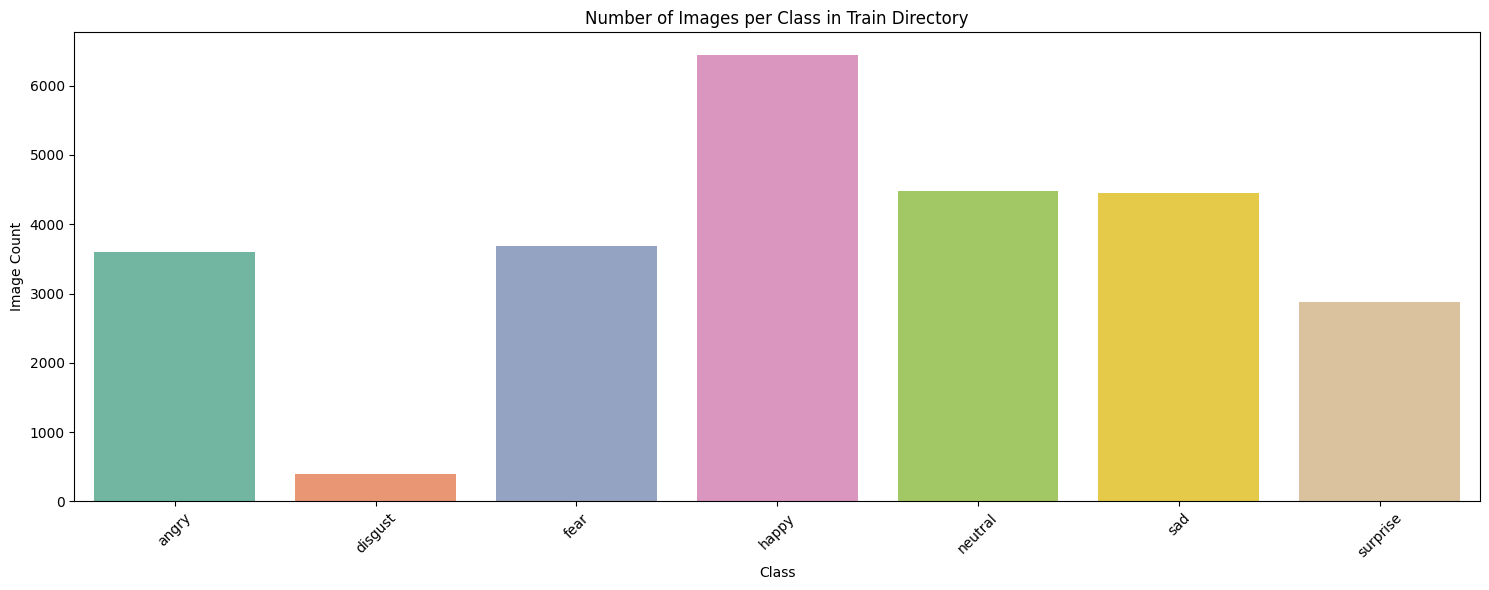

{'angry': 3594,
 'disgust': 393,
 'fear': 3693,
 'happy': 6448,
 'neutral': 4484,
 'sad': 4445,
 'surprise': 2885}

In [3]:
class_counts = {}
train_dir = os.path.join('fed2013', 'train')

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        count = len(os.listdir(class_path))
        class_counts[class_name] = count

# Convert to DataFrame
df_counts = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Image Count'])

# Plot using Seaborn
plt.figure(figsize=(15, 6))
sns.barplot(data=df_counts, x='Class', y='Image Count', palette='Set2')
plt.title("Number of Images per Class in Train Directory")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
class_counts

In [4]:
import shutil
import random


# to make test dataset, validation dataset we already have
test_path = os.path.join('fed2013', 'test')
test_size = 0.1
main_data_path = os.path.join('fed2013', 'train')

if not os.path.isdir(test_path):
    for emotion_class in os.listdir(main_data_path):
        files = os.listdir(os.path.join(main_data_path, emotion_class))
        n_files = len(files)
        random_subsample = random.sample(files, int(n_files*test_size))
        test_class_path = os.path.join(test_path, emotion_class)
        os.makedirs(test_class_path, exist_ok=True)
        for file in random_subsample:
            shutil.move(os.path.join(main_data_path, emotion_class, file), os.path.join(test_class_path, file))

In [5]:
# # calculate images' mean and std
# runn_mean = 0
# runn_std = 0
# total_files = 0
# for root, dirs, files in os.walk(os.path.join('fed2013', 'train')):
#     total_files+=len(files)
#     for file in files:
#         img = cv2.imread(os.path.join(root, file), cv2.IMREAD_GRAYSCALE)
#         runn_mean+=(img / 255.0).mean()
#         runn_std+=(img / 255.0).std()
# mean = runn_mean / total_files
# std = runn_std / total_files

# print('mean {} std {}'.format(mean, std))
# mean = [0.508]
# std = [0.255]

In [6]:
# # fix image distribution disbalance
# from torchvision.utils import save_image

# augm_transform = transforms.Compose([
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.RandomAdjustSharpness(1.3, p = 0.5),
#     transforms.ToTensor()
# ])

# root = os.path.join('fed2013', 'train')
# max_images_per_class = max(class_counts.values())
# for folder in os.listdir(root):
#     folder_dest = os.path.join(root, folder)
#     files = os.listdir(folder_dest)
#     for _ in range(max_images_per_class - len(files)):
#         file = files[random.randint(0, len(files)-1)]
#         img = Image.open(os.path.join(folder_dest, file))
#         augm_img = augm_transform(img)
#         img_name, ext = file.split('.')
#         new_img_name = img_name+f'_{random.randint(1,10000)}.'+ ext
#         save_image(augm_img, os.path.join(folder_dest, new_img_name))

In [7]:
img_size = (224, 224)
mean = [0.508]
std = [0.255]
# original image size = (48, 48)

augm_transforms = torch.nn.ModuleList([
                   transforms.RandomCrop((45, 45)),
                   transforms.RandomRotation((-10, 10)),
                   transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.1, hue=0.1)
                  ])

train_transform = transforms.Compose([
                        transforms.Grayscale(num_output_channels=1),
                        transforms.RandomHorizontalFlip(p=0.5),
                        transforms.RandomApply(augm_transforms, p=0.5),
                        transforms.Resize(img_size, interpolation=transforms.InterpolationMode.BICUBIC),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=mean, std=std)
                   ])

valtest_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(img_size, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [8]:
root_data_dir = 'fed2013'
train_dir = os.path.join(root_data_dir, 'train')
val_dir = os.path.join(root_data_dir, 'validation')
test_dir = os.path.join(root_data_dir, 'test')
train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transform)

val_dataset = torchvision.datasets.ImageFolder(val_dir, valtest_transform)

test_dataset = torchvision.datasets.ImageFolder(test_dir, valtest_transform)

In [9]:
class_names = list(os.listdir(train_dir))

In [10]:
batch_size = 64
num_workers = 4
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# EDA

In [11]:
print("train size : {} val size : {} test size {}".format(len(train_dataloader), len(val_dataloader), len(test_dataloader)))

train size : 406 val size : 111 test size 45


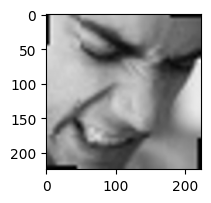

In [12]:
batch_data, batch_labels = next(iter(train_dataloader))
fig, ax = plt.subplots(figsize=(2,4))
plt.imshow(batch_data[0].permute(1, 2, 0).numpy(), cmap='gray');

In [13]:
batch_data[0].shape

torch.Size([1, 224, 224])

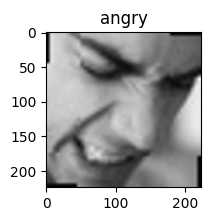

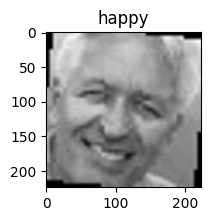

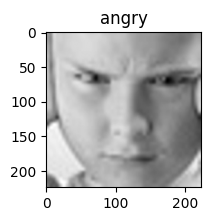

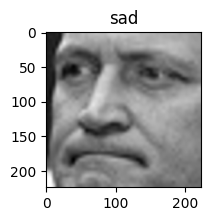

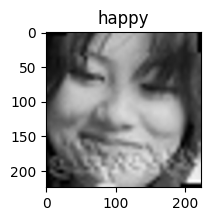

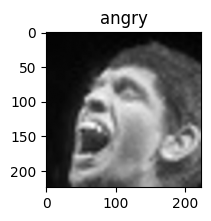

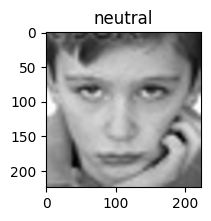

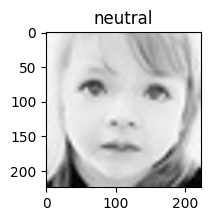

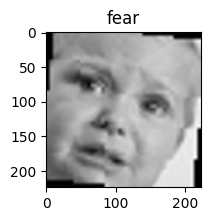

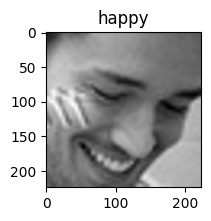

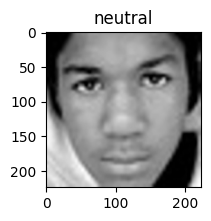

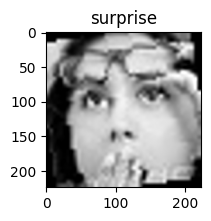

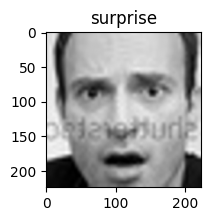

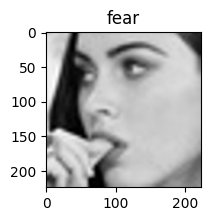

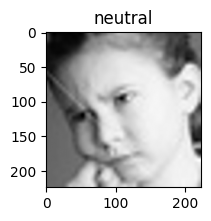

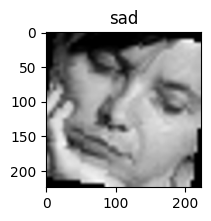

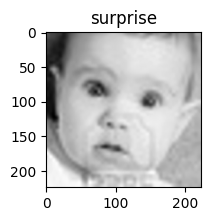

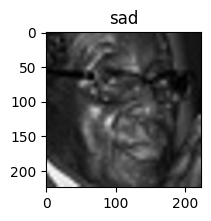

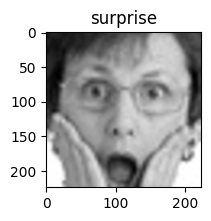

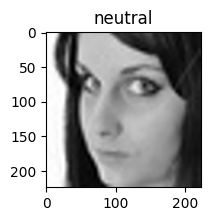

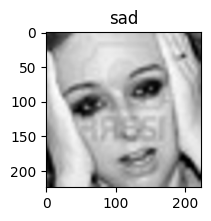

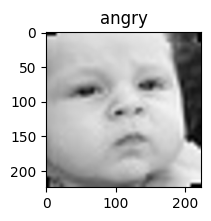

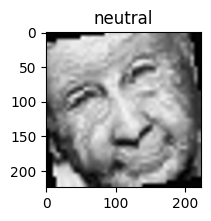

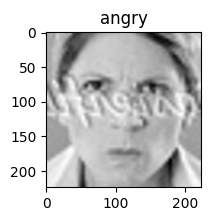

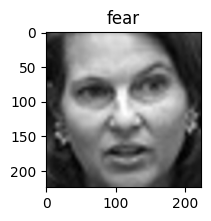

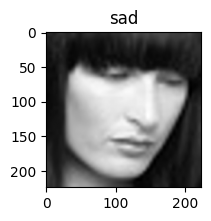

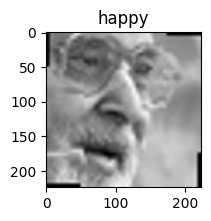

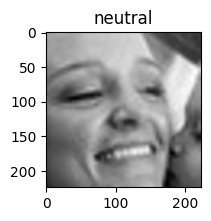

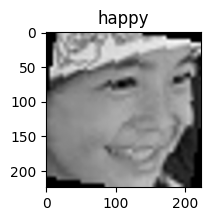

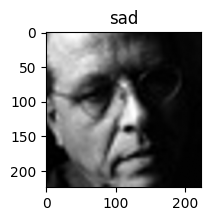

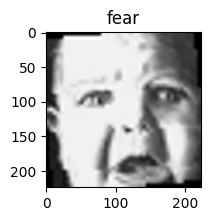

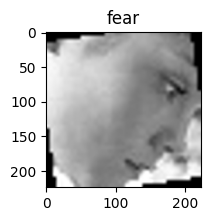

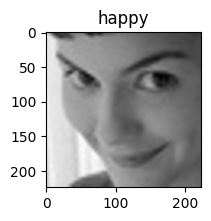

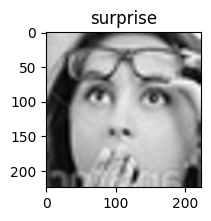

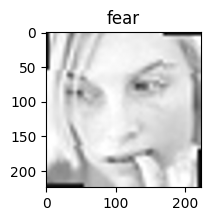

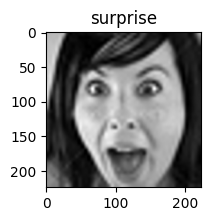

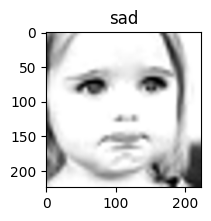

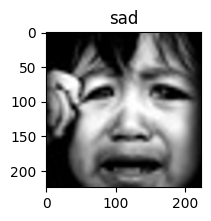

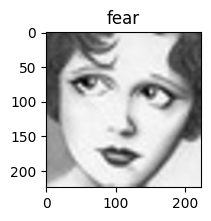

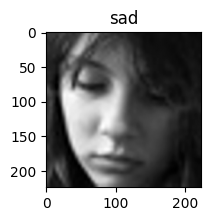

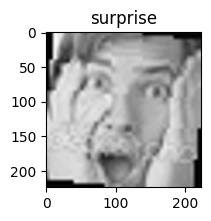

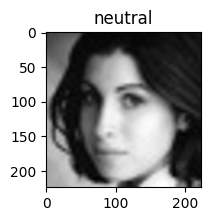

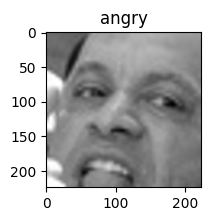

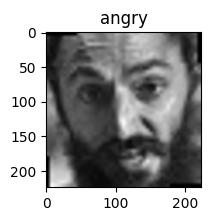

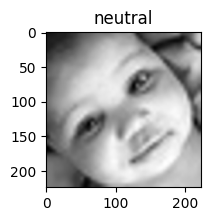

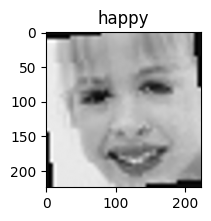

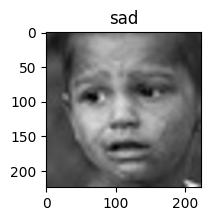

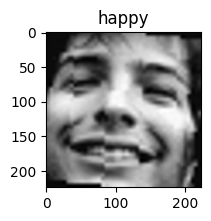

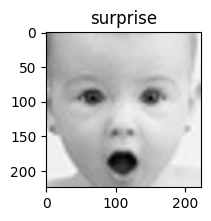

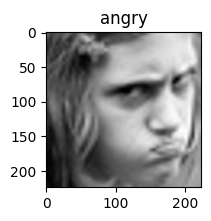

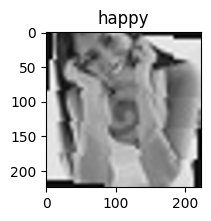

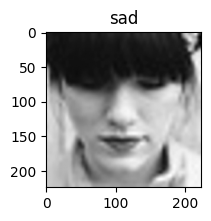

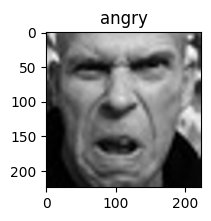

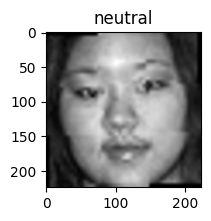

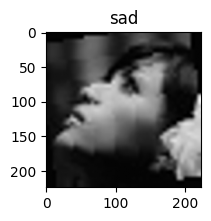

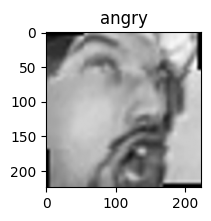

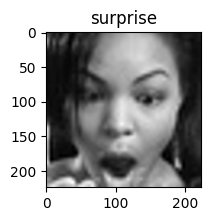

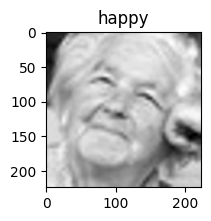

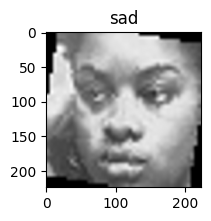

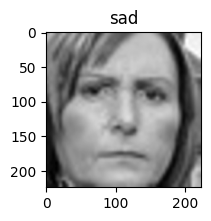

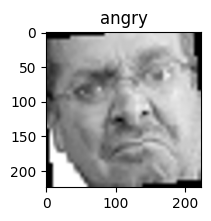

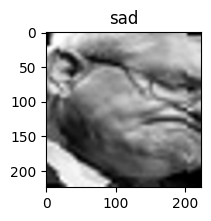

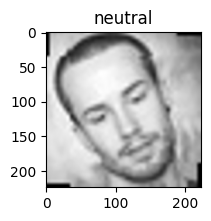

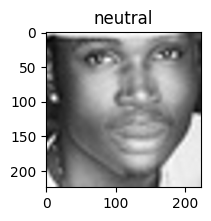

In [14]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    fig, ax = plt.subplots(figsize=(2,4))
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.show()
    plt.pause(0.001)

for x_item, y_item in zip(batch_data, batch_labels):
    show_input(x_item, title=class_names[y_item])

In [15]:
total_objs = sum(class_counts.values())
weights = torch.zeros(len(class_names))
for i, cl in enumerate(class_names):
    weights[i]=total_objs/class_counts[cl]
    weights[i] = weights[i] / 10
weights

tensor([0.7218, 6.6010, 0.7025, 0.4023, 0.5785, 0.5836, 0.8992])

# Init model

In [16]:
n_classes = len(class_names)
# model = CustomResnet18(n_classes)
model = CustomMobilenetv3small(n_classes)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = "cpu"
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()# weight=weights)
# loss.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Train model

In [17]:
from copy import deepcopy


def train_model(model, loss, optimizer, scheduler, num_epochs):
    train_loss = torch.zeros(num_epochs)
    val_loss = torch.zeros(num_epochs)
    train_acc = torch.zeros(num_epochs)
    val_acc = torch.zeros(num_epochs)
    best_acc = 0
    best_model = deepcopy(model)
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            if phase == 'train':
                train_loss[epoch] = epoch_loss
                train_acc[epoch] = epoch_acc
            else:
                val_loss[epoch] = epoch_loss
                val_acc[epoch] = epoch_acc
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model = deepcopy(model)
                    print('new best model!', flush=True)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return train_loss, val_loss, train_acc, val_acc, best_model


def validate_model(model, loss_f, dataloader, device: str):
    total_loss = 0
    model.eval()
    model.to(device)
    running_acc = 0
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            preds = model(inputs)
            preds_class = preds.argmax(dim=1)
            running_acc += (preds_class == labels.data).float().mean()
            loss_value = loss_f(preds, labels)
            total_loss += loss_value.item()
    acc = running_acc / len(dataloader)
    mean_loss = total_loss / len(dataloader)
    print('Loss: {:.4f} acc: {:.4f}'.format(mean_loss, acc), flush=True)


def get_preds_labels(model, loss_f, dataloader, device: str) -> tuple:
    model.eval()
    model.to(device)
    model_preds = []
    target_labels = []
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            preds = model(inputs)
            preds_class = preds.argmax(dim=1)
            model_preds.extend(preds_class.ravel().tolist())
            target_labels.extend(labels.ravel().tolist())
            
    return model_preds, target_labels

In [18]:
len(train_dataloader.dataset)

25942

In [19]:
num_epochs=30
train_loss, val_loss, train_acc, val_acc, model = train_model(model, loss, optimizer, scheduler, num_epochs=num_epochs)

Epoch 0/29:


D:\Python\Environments\python312_main_venv\Lib\site-packages\torch\optim\lr_scheduler.py:182: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
100%|████████████████████████████████████████████████████████████████████████████████| 406/406 [03:06<00:00,  2.18it/s]

train Loss: 1.2179 Acc: 0.5362



100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [01:15<00:00,  1.47it/s]

new best model!
val Loss: 1.3857 Acc: 0.5162
Epoch 1/29:



100%|████████████████████████████████████████████████████████████████████████████████| 406/406 [03:16<00:00,  2.07it/s]

train Loss: 1.0160 Acc: 0.6146



100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [00:51<00:00,  2.15it/s]

new best model!
val Loss: 1.0007 Acc: 0.6338
Epoch 2/29:



100%|████████████████████████████████████████████████████████████████████████████████| 406/406 [03:17<00:00,  2.06it/s]

train Loss: 0.9389 Acc: 0.6439



100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [00:51<00:00,  2.15it/s]

new best model!
val Loss: 1.0017 Acc: 0.6384
Epoch 3/29:



100%|████████████████████████████████████████████████████████████████████████████████| 406/406 [03:17<00:00,  2.06it/s]

train Loss: 0.8832 Acc: 0.6685



100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [00:51<00:00,  2.14it/s]

val Loss: 1.0293 Acc: 0.6187
Epoch 4/29:



100%|████████████████████████████████████████████████████████████████████████████████| 406/406 [03:19<00:00,  2.04it/s]

train Loss: 0.7562 Acc: 0.7169



100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [00:53<00:00,  2.09it/s]

new best model!
val Loss: 0.9268 Acc: 0.6619
Epoch 5/29:



100%|████████████████████████████████████████████████████████████████████████████████| 406/406 [03:38<00:00,  1.86it/s]

train Loss: 0.6992 Acc: 0.7396



100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [05:09<00:00,  2.79s/it]


new best model!
val Loss: 0.9191 Acc: 0.6796
Epoch 6/29:


100%|████████████████████████████████████████████████████████████████████████████████| 406/406 [09:23<00:00,  1.39s/it]

train Loss: 0.6465 Acc: 0.7594



100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [01:22<00:00,  1.35it/s]

val Loss: 0.9771 Acc: 0.6609
Epoch 7/29:



100%|████████████████████████████████████████████████████████████████████████████████| 406/406 [07:03<00:00,  1.04s/it]

train Loss: 0.6019 Acc: 0.7722



100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [00:59<00:00,  1.85it/s]

val Loss: 0.9432 Acc: 0.6760
Epoch 8/29:



100%|████████████████████████████████████████████████████████████████████████████████| 406/406 [07:03<00:00,  1.04s/it]

train Loss: 0.5556 Acc: 0.7936



100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [01:03<00:00,  1.76it/s]

val Loss: 0.9665 Acc: 0.6768
Epoch 9/29:



100%|████████████████████████████████████████████████████████████████████████████████| 406/406 [06:37<00:00,  1.02it/s]

train Loss: 0.4423 Acc: 0.8371



100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [00:57<00:00,  1.95it/s]

new best model!
val Loss: 0.9767 Acc: 0.6945
Epoch 10/29:



100%|████████████████████████████████████████████████████████████████████████████████| 406/406 [06:56<00:00,  1.02s/it]

train Loss: 0.3968 Acc: 0.8532



100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [01:21<00:00,  1.36it/s]

val Loss: 1.0561 Acc: 0.6860
Epoch 11/29:



100%|████████████████████████████████████████████████████████████████████████████████| 406/406 [07:31<00:00,  1.11s/it]

train Loss: 0.3614 Acc: 0.8659



100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [00:59<00:00,  1.86it/s]

new best model!
val Loss: 1.1136 Acc: 0.6963
Epoch 12/29:



100%|████████████████████████████████████████████████████████████████████████████████| 406/406 [09:11<00:00,  1.36s/it]

train Loss: 0.3304 Acc: 0.8791



100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [02:31<00:00,  1.36s/it]

val Loss: 1.1170 Acc: 0.6937
Epoch 13/29:



100%|████████████████████████████████████████████████████████████████████████████████| 406/406 [07:29<00:00,  1.11s/it]

train Loss: 0.3134 Acc: 0.8871



100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [01:23<00:00,  1.33it/s]

val Loss: 1.1808 Acc: 0.6913
Epoch 14/29:



100%|████████████████████████████████████████████████████████████████████████████████| 406/406 [07:11<00:00,  1.06s/it]

train Loss: 0.2479 Acc: 0.9117



100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [01:29<00:00,  1.25it/s]

new best model!


val Loss: 1.2340 Acc: 0.6973
Epoch 15/29:


100%|████████████████████████████████████████████████████████████████████████████████| 406/406 [07:22<00:00,  1.09s/it]

train Loss: 0.2320 Acc: 0.9163



100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [01:25<00:00,  1.30it/s]

val Loss: 1.2488 Acc: 0.6970
Epoch 16/29:



100%|████████████████████████████████████████████████████████████████████████████████| 406/406 [06:42<00:00,  1.01it/s]

train Loss: 0.2181 Acc: 0.9229



100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [01:05<00:00,  1.70it/s]

val Loss: 1.3227 Acc: 0.6921
Epoch 17/29:



100%|████████████████████████████████████████████████████████████████████████████████| 406/406 [06:54<00:00,  1.02s/it]

train Loss: 0.2057 Acc: 0.9266



100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [01:01<00:00,  1.79it/s]

val Loss: 1.3424 Acc: 0.6934
Epoch 18/29:



100%|████████████████████████████████████████████████████████████████████████████████| 406/406 [07:42<00:00,  1.14s/it]


train Loss: 0.1940 Acc: 0.9316


100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [01:03<00:00,  1.75it/s]


new best model!
val Loss: 1.3849 Acc: 0.6990
Epoch 19/29:


100%|████████████████████████████████████████████████████████████████████████████████| 406/406 [09:25<00:00,  1.39s/it]


train Loss: 0.1678 Acc: 0.9414


100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [01:17<00:00,  1.43it/s]

val Loss: 1.3809 Acc: 0.6976
Epoch 20/29:



100%|████████████████████████████████████████████████████████████████████████████████| 406/406 [08:44<00:00,  1.29s/it]


train Loss: 0.1637 Acc: 0.9419


100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [01:12<00:00,  1.53it/s]

val Loss: 1.4153 Acc: 0.6937
Epoch 21/29:



100%|████████████████████████████████████████████████████████████████████████████████| 406/406 [09:03<00:00,  1.34s/it]


train Loss: 0.1585 Acc: 0.9429


100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [01:35<00:00,  1.16it/s]

val Loss: 1.4422 Acc: 0.6976
Epoch 22/29:



100%|████████████████████████████████████████████████████████████████████████████████| 406/406 [09:50<00:00,  1.45s/it]


train Loss: 0.1541 Acc: 0.9458


100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [01:08<00:00,  1.62it/s]

val Loss: 1.4703 Acc: 0.6934
Epoch 23/29:



100%|████████████████████████████████████████████████████████████████████████████████| 406/406 [07:57<00:00,  1.18s/it]

train Loss: 0.1543 Acc: 0.9455



100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [01:05<00:00,  1.70it/s]

val Loss: 1.4691 Acc: 0.6987
Epoch 24/29:



100%|████████████████████████████████████████████████████████████████████████████████| 406/406 [09:04<00:00,  1.34s/it]

train Loss: 0.1399 Acc: 0.9499



100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [01:49<00:00,  1.01it/s]

val Loss: 1.4659 Acc: 0.6965
Epoch 25/29:



100%|████████████████████████████████████████████████████████████████████████████████| 406/406 [08:18<00:00,  1.23s/it]


train Loss: 0.1394 Acc: 0.9516


100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [01:37<00:00,  1.14it/s]

val Loss: 1.4896 Acc: 0.6962
Epoch 26/29:



100%|████████████████████████████████████████████████████████████████████████████████| 406/406 [07:41<00:00,  1.14s/it]

train Loss: 0.1345 Acc: 0.9540



100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [01:09<00:00,  1.60it/s]


new best model!
val Loss: 1.4886 Acc: 0.7000
Epoch 27/29:


100%|████████████████████████████████████████████████████████████████████████████████| 406/406 [07:39<00:00,  1.13s/it]

train Loss: 0.1357 Acc: 0.9525



100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [01:09<00:00,  1.60it/s]

val Loss: 1.5065 Acc: 0.6977
Epoch 28/29:



100%|████████████████████████████████████████████████████████████████████████████████| 406/406 [07:28<00:00,  1.11s/it]

train Loss: 0.1240 Acc: 0.9578



100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [00:58<00:00,  1.91it/s]

val Loss: 1.5283 Acc: 0.6974
Epoch 29/29:



100%|████████████████████████████████████████████████████████████████████████████████| 406/406 [09:24<00:00,  1.39s/it]

train Loss: 0.1266 Acc: 0.9552



100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [01:13<00:00,  1.52it/s]

val Loss: 1.5265 Acc: 0.6998


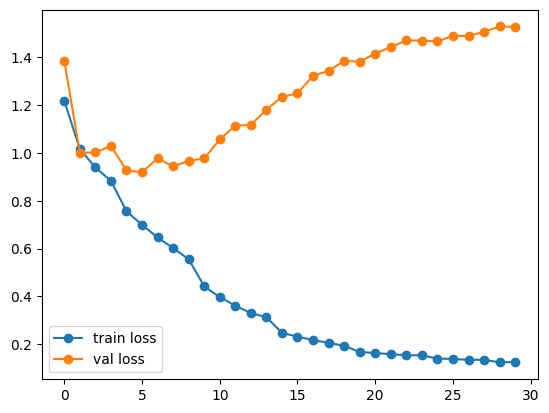

In [20]:
plt.plot(train_loss, label = 'train loss', marker='o')
plt.plot(val_loss, label = 'val loss', marker='o')
plt.legend(loc='best')
plt.show()

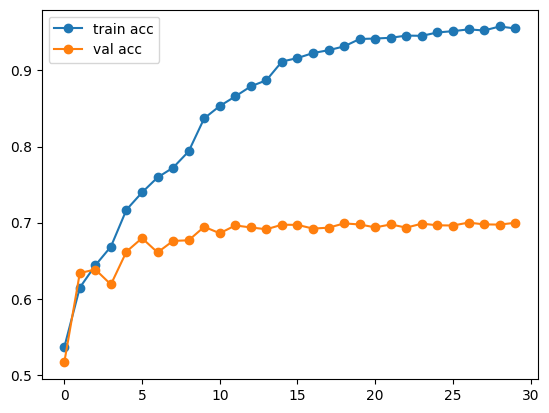

In [21]:
plt.plot(train_acc, label = 'train acc', marker='o')
plt.plot(val_acc, label = 'val acc', marker='o')
plt.legend(loc='best')
plt.show()

# Model's perfromance analysis

In [22]:
val_preds, val_labels = get_preds_labels(model, loss, val_dataloader, device)

100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [01:10<00:00,  1.57it/s]


In [23]:
test_preds, test_labels = get_preds_labels(model, loss, test_dataloader, device)

100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [01:51<00:00,  2.47s/it]


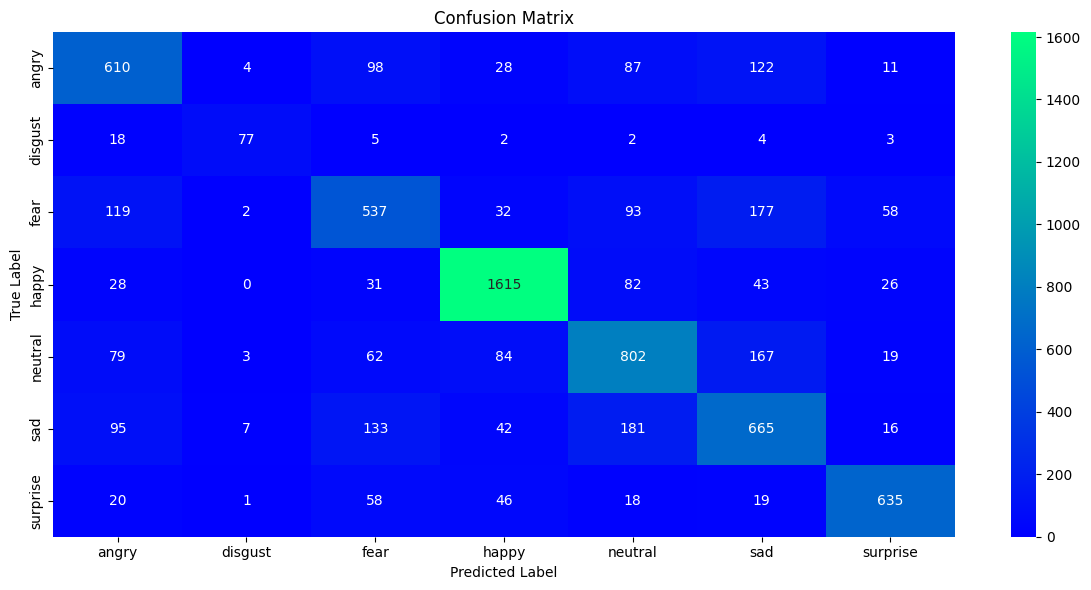

In [24]:
def plot_conf_matrix(labels, preds):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(12, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="winter",xticklabels=class_names,yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

plot_conf_matrix(val_labels, val_preds)

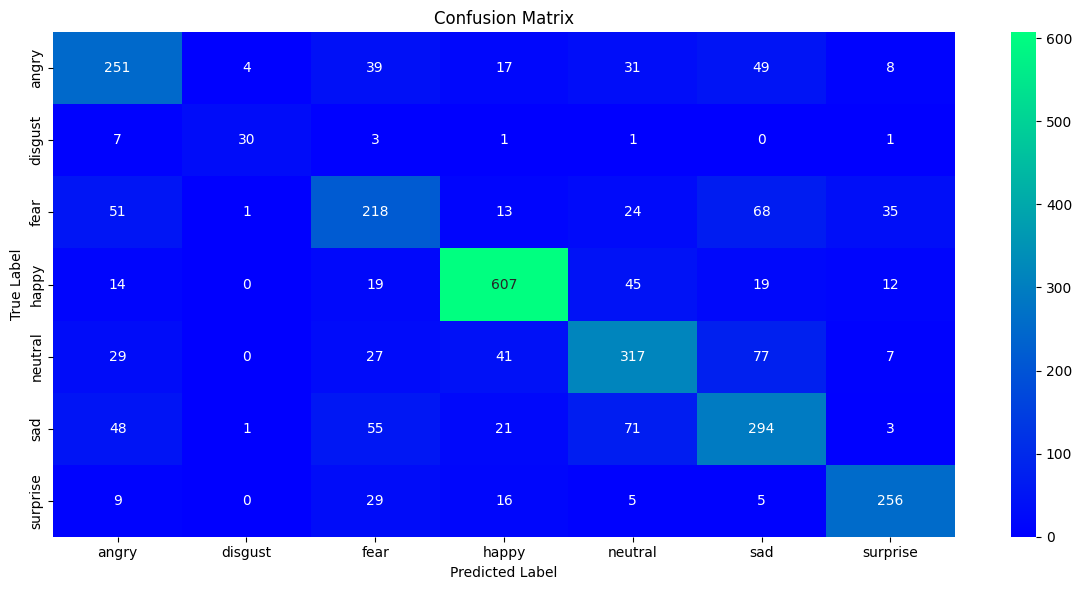

In [25]:
plot_conf_matrix(test_labels, test_preds)

In [26]:
print(classification_report(val_labels, val_preds, target_names=class_names))

              precision    recall  f1-score   support

       angry       0.63      0.64      0.63       960
     disgust       0.82      0.69      0.75       111
        fear       0.58      0.53      0.55      1018
       happy       0.87      0.88      0.88      1825
     neutral       0.63      0.66      0.65      1216
         sad       0.56      0.58      0.57      1139
    surprise       0.83      0.80      0.81       797

    accuracy                           0.70      7066
   macro avg       0.70      0.68      0.69      7066
weighted avg       0.70      0.70      0.70      7066



In [27]:
print(classification_report(test_labels, test_preds, target_names=class_names))

              precision    recall  f1-score   support

       angry       0.61      0.63      0.62       399
     disgust       0.83      0.70      0.76        43
        fear       0.56      0.53      0.55       410
       happy       0.85      0.85      0.85       716
     neutral       0.64      0.64      0.64       498
         sad       0.57      0.60      0.59       493
    surprise       0.80      0.80      0.80       320

    accuracy                           0.69      2879
   macro avg       0.69      0.68      0.69      2879
weighted avg       0.69      0.69      0.69      2879



C:\Users\IlshatGuestAccount\AppData\Local\Temp\ipykernel_8728\3660744395.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_cl = torch.nn.functional.softmax(pred.float()).data.cpu().numpy().argmax(axis=0)


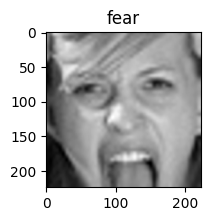

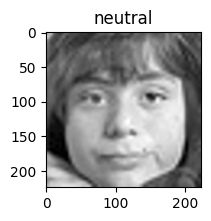

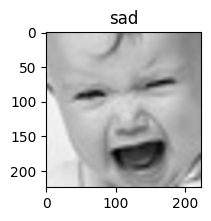

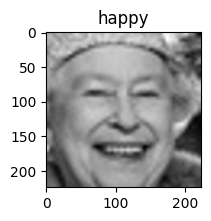

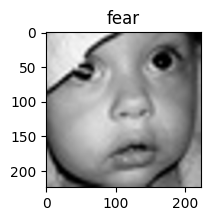

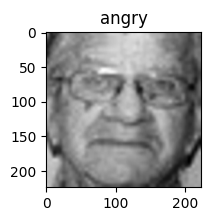

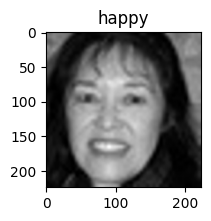

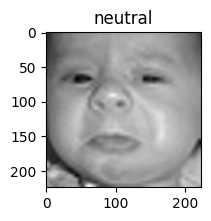

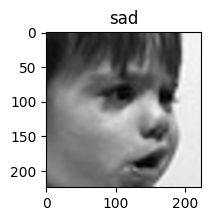

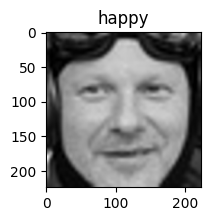

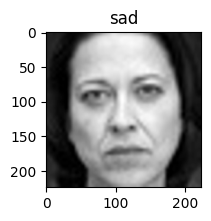

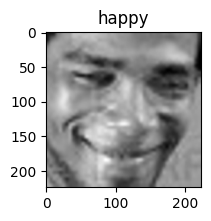

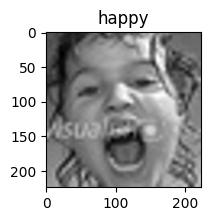

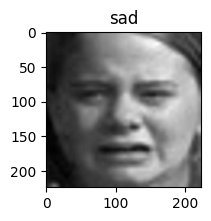

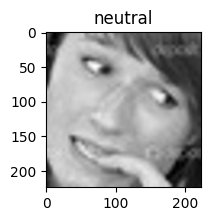

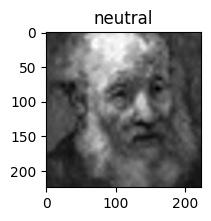

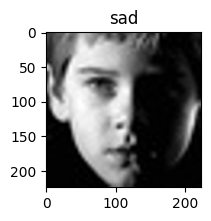

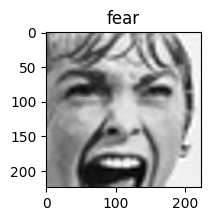

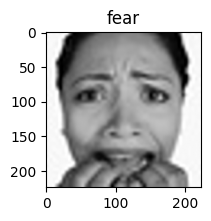

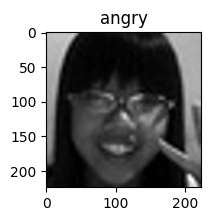

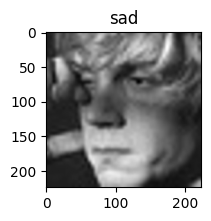

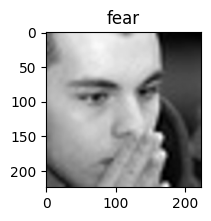

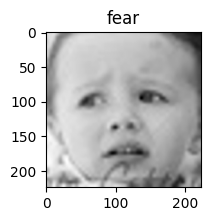

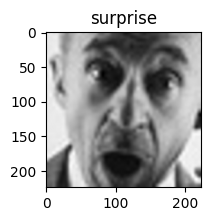

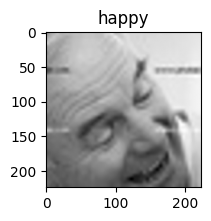

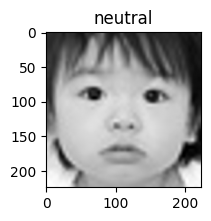

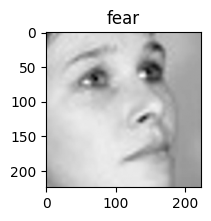

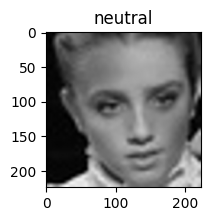

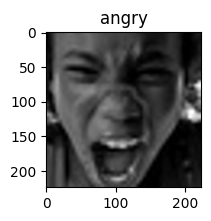

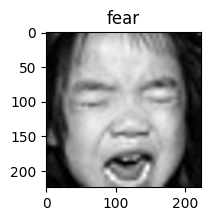

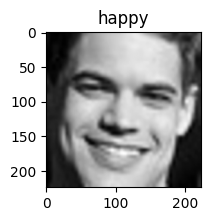

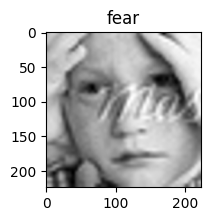

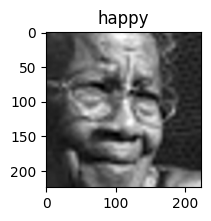

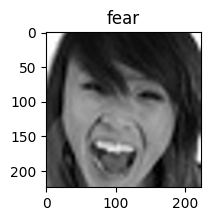

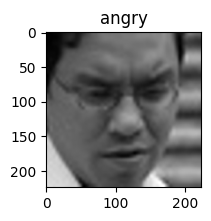

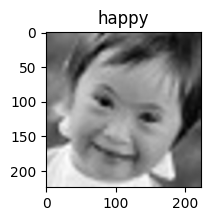

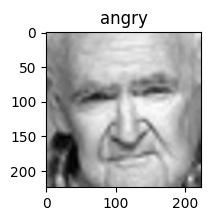

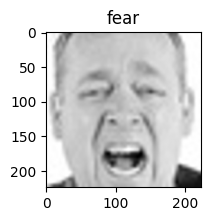

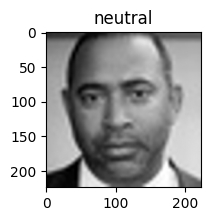

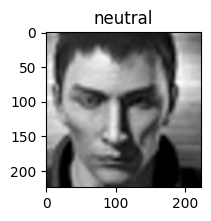

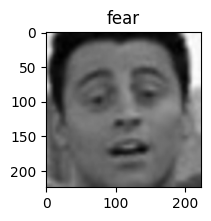

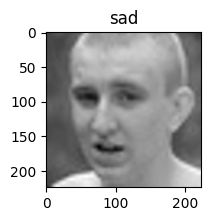

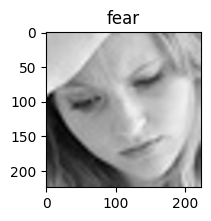

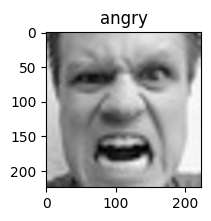

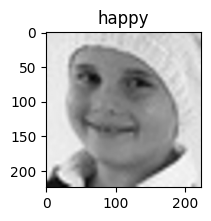

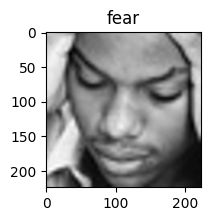

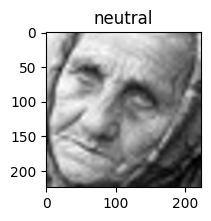

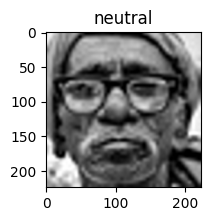

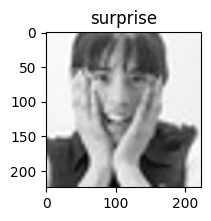

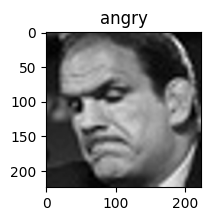

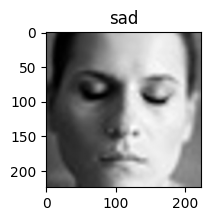

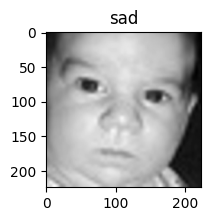

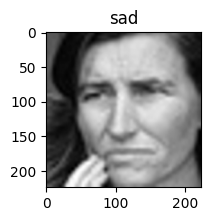

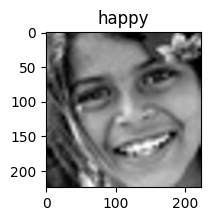

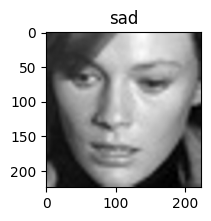

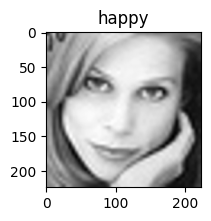

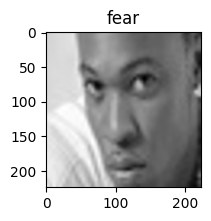

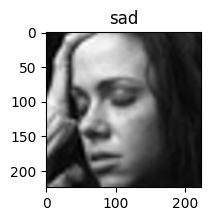

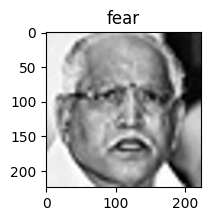

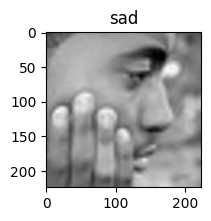

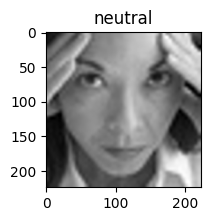

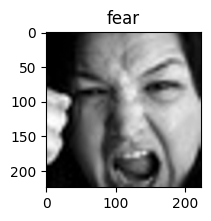

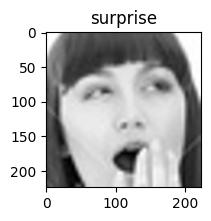

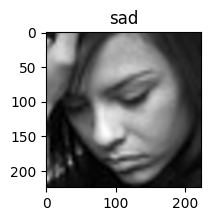

In [28]:
model.to('cpu')

batch_data, batch_labels = next(iter(val_dataloader))

with torch.set_grad_enabled(False):
    preds = model(batch_data)
    
for img, pred in zip(batch_data, preds):
    pred_cl = torch.nn.functional.softmax(pred.float()).data.cpu().numpy().argmax(axis=0)
    img = img.cpu()
    show_input(img, title=class_names[pred_cl])

In [29]:
model_name = 'mobilenet_fed'
# model_name = 'resnet18_fed'
onnx_model_path = os.path.join('SavedModels', f'{model_name}.onnx')
torch_model_path = os.path.join('SavedModels', f'{model_name}.pt')

# Save models

In [30]:
model.to('cpu')
torch.save(model, torch_model_path)

In [31]:
torch.onnx.export(
    model,
    batch_data[0].unsqueeze(0),
    onnx_model_path,
    export_params=True,  # Export trained parameter weights
    opset_version=16,    # ONNX operator set version
    do_constant_folding=True, # Optimize constants in the graph
    input_names=['input'],   # Name for the input node
    output_names=['output'], # Name for the output node
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}} # Allow dynamic batch size
)

In [32]:
import json

config = {'class_names' : class_names,
          'img_size' : img_size,
          'inp_size' : batch_data[0].unsqueeze(0).shape,
          'mean': mean,
          'std': std,
          'onnx_model_path': onnx_model_path,
          'torch_model_path': torch_model_path
         }

with open(os.path.join('SavedModels', 'config.json'),'w') as f:
    json.dump(config, f, indent=4)